# Least Squares Policy Iteration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = 10, 6

In [4]:
%load_ext autoreload
%autoreload 2

## Environment

Let's get a really simple environment going -- we'll try to replicate
the paper's results with the [NChain-v0](https://gym.openai.com/envs/NChain-v0/) 
environment.  The environment wrapped up in OpenAI puts a large reward at the
end of the chain, so the optimal strategy is always to go right.  The problem
is made slightly more difficult in that there is a high probability of 
movement error, and you always receive a small reward for going left.

We can solve this pretty easily (1-3 iterations of LSPI with only quadratic 
basis functions).

In [5]:
import gym

In [6]:
length = 10

env = gym.make('NChain-v0', n=length)
env.reset()

0

In [7]:
env.action_space

Discrete(2)

In [8]:
env.observation_space

Discrete(10)

In [9]:
obs, reward, done, _ = env.step(0)

## LSTDQ: Least Squares Temporal Difference Q-Learning

In [10]:
import abc

class Policy(object, metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def __call__(self, state):
        """
        Returns an action to take given a state.
        """
        pass
    
    @abc.abstractmethod
    def update(self, weights) -> float:
        """
        Returns the "difference" between the current weights, and new weights.
        """
        pass
    
class RandomPolicy(Policy):
    
    def __init__(self, env: gym.Env):
        """
        Creates a random policy.
        """
        self._env = env
        
    def __call__(self, state):
        assert state in self._env.observation_space
        return self._env.action_space.sample()
    
    def update(self, weights):
        return 0.0

In [11]:
class Basis(object, metaclass=abc.ABCMeta):
    """
    Class to represent our basis functions.
    """
    
    @abc.abstractmethod
    def __call__(self, state, action) -> np.ndarray:
        """
        Returns a numpy array of each basis function evaluated at 
        the state and action specified.
        """
        
        pass
    
    @abc.abstractproperty
    def rank(self) -> int:
        """
        Returns the rank of this basis.
        """
        
        pass
    
class IndActionPolyStateBasis(Basis):
    """
    Implements a basis that provides bases polynomial in state, 
    each of which is multipled by an indicator varible for each 
    action.
    """
    
    def __init__(self, action_space: gym.spaces.Discrete, observation_space: gym.spaces.Space, order: int = 2):
        
        self._action_space = action_space
        self._observation_space = observation_space
        
        self._num_actions = self._action_space.n
        self._observation_dim = np.product(self._observation_space.shape) if len(self._observation_space.shape) else 1
        
        # rank of this basis
        self._order = order
        self._rank = self._num_actions * self._observation_dim * (self._order + 1)
        
    @property
    def rank(self):
        return self._rank
    
    def _eval_polynomial(self, state):
        """
        Evaluates our polynomial basis functions at each element of the given state,
        which is either a single number or an array.
        """
        
        return np.array([state**power for power in range(self._order + 1)]).flatten()
    
    def __call__(self, state, action):
        """
        Computes the function ϕ(s, a) for this basis.
        """
        
        assert state in self._observation_space
        assert action in self._action_space
        
        phi = np.zeros(self.rank)
        dim = self.rank // self._num_actions
        
        phi[action * dim: (action + 1) * dim] = self._eval_polynomial(state)
        
        return phi

In [12]:
basis = IndActionPolyStateBasis(action_space=gym.spaces.Discrete(2), observation_space=gym.spaces.Discrete(10), order=2)
basis(2, 1)

array([ 0.,  0.,  0.,  1.,  2.,  4.])

In [13]:
basis = IndActionPolyStateBasis(action_space=gym.spaces.Discrete(2), observation_space=gym.make("CartPole-v0").observation_space, order=2)
basis(np.ones(4) * 0.1, 1)

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  1.  ,  1.  ,  1.  ,  1.  ,  0.1 ,  0.1 ,
        0.1 ,  0.1 ,  0.01,  0.01,  0.01,  0.01])

In [14]:
from typing import Iterable, List
from numpy.linalg import LinAlgError

class LSTDQ(object):
    
    def __init__(self, basis: Basis, discount = 0.9, gamma = 1e-3):
        
        self._basis = basis
        self._k = self._basis.rank
        self._discount = discount
        self._gamma = gamma
        
    def fit(self, data: Iterable, policy: Policy):
        """
        Performs an iteration of LSTDQ.  
        """
        
        A = np.eye(self._k) * self._gamma
        b = np.zeros((self._k,))
        
        for state, action, reward, nextstate in data:
            phi = self._basis(state, action)
            phiprime = self._basis(nextstate, policy(nextstate))
            
            A += np.outer(phi, phi - self._discount * phiprime)
            b += reward * phi
            
        try:
            self.weights_ = np.linalg.inv(A) @ b
        except LinAlgError as e:
            print(f"A is uninvertable:\n {A}")
            self.weights_ = np.zeros((self._k,))
        
        return self

In [80]:
def generate_sample_data(num_samples, env: gym.Env, policy: Policy):
    
    state = env.reset()
    
    data = []
    
    for _ in range(int(num_samples)):
        action = policy(state)
        nextstate, reward, done, _ = env.step(action)
        data.append((state, action, reward, nextstate))
        
        if done:
            state = env.reset()
        else:
            state = nextstate
        
    return data

In [17]:
data = generate_sample_data(1e3, env, RandomPolicy(env))

basis = IndActionPolyStateBasis(env.action_space, env.observation_space, order=2)
lstdq = LSTDQ(basis, discount=0.1)
lstdq = lstdq.fit(data, RandomPolicy(env))

In [19]:
class DiscreteActionBasisPolicy(Policy):
    
    def __init__(self, space: gym.spaces.Discrete, basis: Basis, weights: np.ndarray):
        
        self._space = space
        
        assert basis.rank == len(weights)
        self._basis = basis
        self._weights = weights
        
        self.history_ = [self._weights]
        
    def __call__(self, state):
        """
        Returns the optimal action at this state.
        """
        
        qvalues = np.zeros(self._space.n)
        for action in range(self._space.n):
            phi = self._basis(state, action)
            qvalues[action] = phi @ self._weights
            
        return np.argmax(qvalues)
    
    def update(self, weights):
        """
        Updates the weights of this policy.
        """
        
        self.history_.append(weights)
        
        diff = np.linalg.norm(self._weights - weights)
        self._weights = weights
        return diff

In [20]:
basis = IndActionPolyStateBasis(env.action_space, env.observation_space, order=2)
dabp = DiscreteActionBasisPolicy(env.action_space, basis, lstdq.weights_)
dabp(1)

1

In [21]:
class LSPI(object):
    
    def __init__(self, optimizer: LSTDQ, policy: Policy, max_iter = 50, epsilon = 1e-3):
        
        self._optimizer = optimizer
        self._policy = policy
        
        self._max_iter = max_iter
        self._epsilon = epsilon
        
    def fit(self, data: List):
        
        for self.itr_ in range(self._max_iter):
            self._optimizer.fit(data, self._policy)
            diff = self._policy.update(self._optimizer.weights_)
#             print(self._optimizer.weights_)
#             print(diff)
            if (diff < self._epsilon):
                break
                
        return self
    
    @property
    def policy(self):
        return self._policy

## Running LSPI on OpenAI's NChain-v0 environment

In [24]:
data = generate_sample_data(1e3, env, RandomPolicy(env))
lstdq = LSTDQ(basis, discount=0.7)
basis = IndActionPolyStateBasis(env.action_space, env.observation_space, order = 2)
dabp = DiscreteActionBasisPolicy(env.action_space, basis, np.zeros(basis.rank))

In [25]:
lspi = LSPI(lstdq, dabp, max_iter=50, epsilon=1e-5)
lspi.fit(data)

In [26]:
lspi.itr_

3

In [27]:
for state in range(env.observation_space.n):
    print(lspi.policy(state))

1
1
1
1
1
1
1
1
1
1


As desired, the learned optimal action for all states is to move to the right.

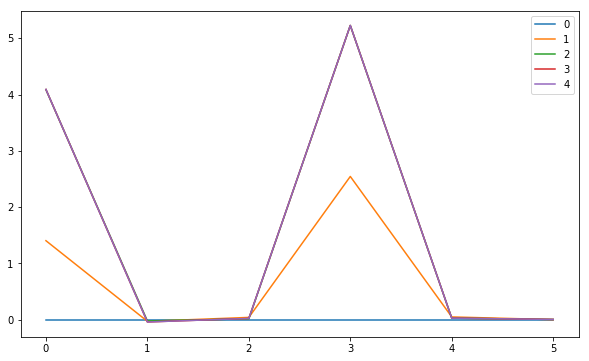

In [28]:
for ind, line in enumerate(lspi.policy.history_):
    plt.plot(line, label=f"{ind}")
plt.legend()

## More complicated chain problems

In the [LSPI paper](https://www2.cs.duke.edu/research/AI/LSPI/) they test on some more complex chains:  

* chains with rewards on either end 
* chains with rewards in the middle

I grabbed [the NChain-v0 code](https://github.com/openai/gym/blob/master/gym/envs/toy_text/nchain.py)
from OpenAI's github, and modified it 
to support chains of this structure in the file 
[environments.py](./environments.py).

In [43]:
from environments import NChainEnv

length = 10

# first and last states have a reward
reward = np.zeros(length)
reward[2] = 1
reward[7] = 1

env = NChainEnv(reward, slip=0.0, wrap=False)

In [52]:
data = generate_sample_data(1e4, env, RandomPolicy(env))
basis = IndActionPolyStateBasis(env.action_space, env.observation_space, order=3)
lstdq = LSTDQ(basis, discount=0.7)
dabp = DiscreteActionBasisPolicy(env.action_space, basis, np.zeros(basis.rank))

In [53]:
lspi = LSPI(lstdq, dabp, max_iter=100, epsilon=1e-3)
lspi.fit(data)

In [54]:
lspi.itr_

4

In [55]:
policy = [lspi.policy(state) for state in range(env.observation_space.n)]
policy

[1, 1, 0, 0, 0, 1, 1, 1, 0, 0]

In [56]:
expected = np.array([1, 1, 0, 0, 0, 1, 1, 1, 0, 0])

In [57]:
policies = []
for test in range(20):
    lspi.fit(data)
    policy = [lspi.policy(state) for state in range(env.observation_space.n)]
    policies.append(policy)

In [58]:
np.mean([pol == expected for pol in policies])

1.0

## Cartpole

In [59]:
env = gym.make("CartPole-v0")

In [60]:
env

<TimeLimit<CartPoleEnv<CartPole-v0>>>

In [61]:
env.action_space

Discrete(2)

In [62]:
env.observation_space

Box(4,)

In [64]:
state = env.reset()

In [65]:
state

array([-0.02951925,  0.00054079, -0.02180742, -0.02778502])

In [118]:
data = generate_sample_data(1e4, env, RandomPolicy(env))
basis = IndActionPolyStateBasis(env.action_space, env.observation_space, order=8)
lstdq = LSTDQ(basis, discount=0.7)
dabp = DiscreteActionBasisPolicy(env.action_space, basis, np.zeros(basis.rank))

In [119]:
lspi = LSPI(lstdq, dabp, max_iter=50, epsilon=1e-3)
lspi.fit(data)

In [120]:
lspi.itr_

15

In [ ]:
for ind, line in enumerate(lspi.policy.history_):
    plt.plot(line, label=f"{ind}")
plt.legend()

In [121]:
numsteps = []

for episode in range(1000):
    state = env.reset()
    done = False
    steps = 0
    while not done:
        action = lspi.policy(state)
        state, reward, done, _ = env.step(action)
        steps += 1
    numsteps.append(steps)
#     print(f"Episode {episode}, Steps: {steps}")

(array([ 111.,    0.,    0.,  412.,    0.,    0.,  432.,    0.,    0.,   45.]),
 array([  8. ,   8.3,   8.6,   8.9,   9.2,   9.5,   9.8,  10.1,  10.4,
         10.7,  11. ]),
 <a list of 10 Patch objects>)

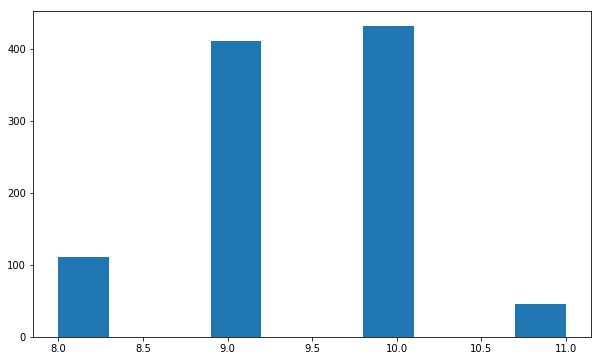

In [122]:
plt.hist(numsteps)

In [107]:
numsteps = []
policy = RandomPolicy(env)

for episode in range(1000):
    state = env.reset()
    done = False
    steps = 0
    while not done:
        action = policy(state)
        state, reward, done, _ = env.step(action)
        steps += 1
    numsteps.append(steps)
#     print(f"Episode {episode}, Steps: {steps}")

(array([ 369.,  345.,  172.,   70.,   21.,   10.,    9.,    2.,    1.,    1.]),
 array([  8.,  17.,  26.,  35.,  44.,  53.,  62.,  71.,  80.,  89.,  98.]),
 <a list of 10 Patch objects>)

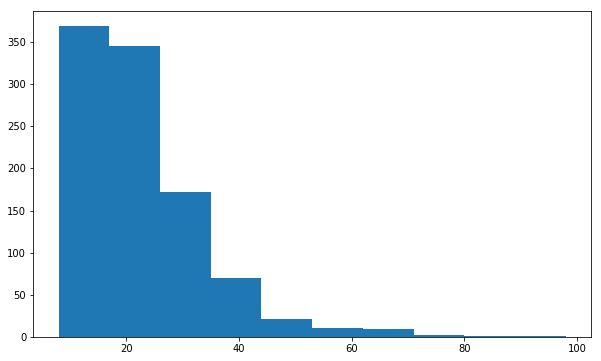

In [108]:
plt.hist(numsteps)